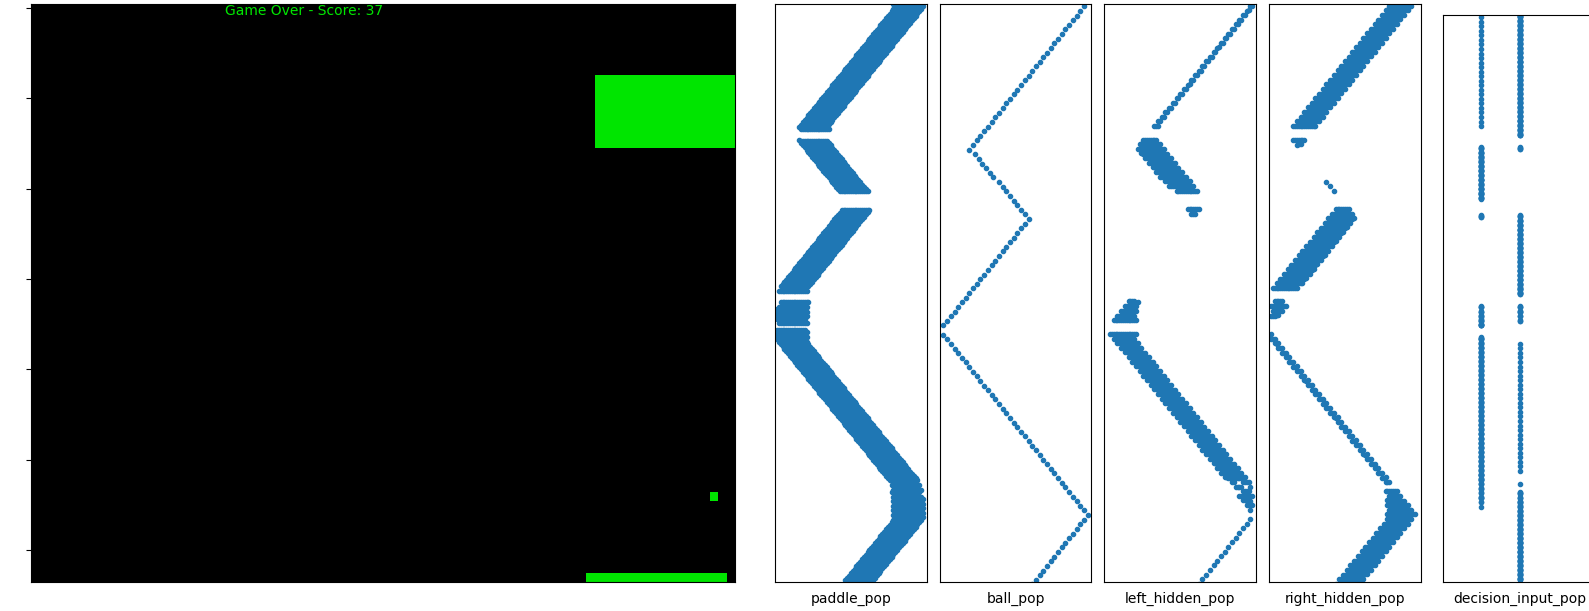

2022-07-13 15:18:42 INFO: Receive callback functools.partial(<function handle_vis_spikes at 0x7f75af561b80>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f75af542040>) registered to label breakout1
2022-07-13 15:18:42 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f75af561c10>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f75af542040>) registered to label paddle_pop
2022-07-13 15:18:42 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f75af561c10>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f75af542040>) registered to label ball_pop
2022-07-13 15:18:42 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f75af561c10>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f75af542040>) registered to label left_hidden_pop
2022-07-13 15:18:42 INFO: Receive callback functools.partial(<function hand

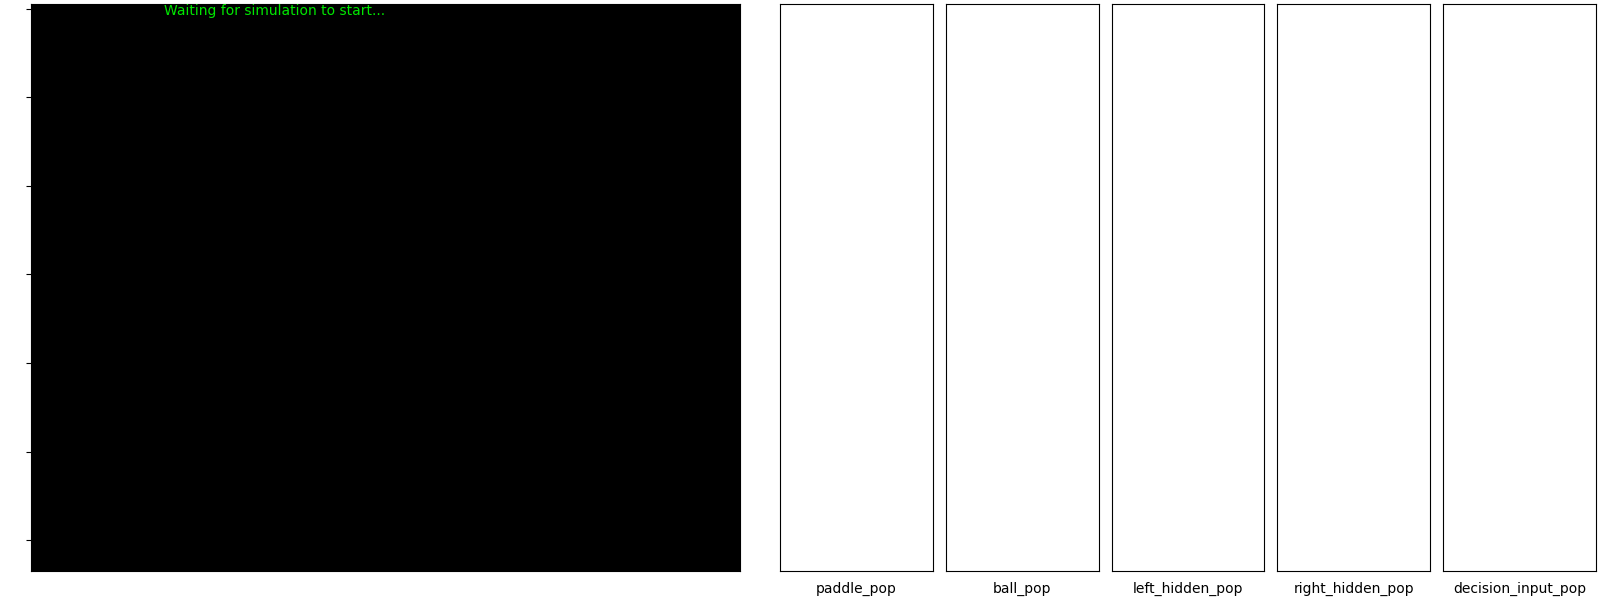

In [1]:
import spynnaker8 as p
from spinn_gym.games.breakout.visualise_jupyter import jupyter_visualiser
from spinn_gym.games.breakout.automated_breakout import (
    AutomatedBreakout, X_RES, X_SCALE, Y_RES, Y_SCALE)

# ----------------------------------------------------------------------------------------------------------------------
# Initialise Simulation and Parameters
# ----------------------------------------------------------------------------------------------------------------------
run_time_seconds = 60
breakout = AutomatedBreakout(time_scale_factor=2)

# ----------------------------------------------------------------------------------------------------------------------
# Configure Visualiser
# ----------------------------------------------------------------------------------------------------------------------
jupyter_visualiser(breakout, X_RES, X_SCALE, Y_RES, Y_SCALE, 
                   [breakout.paddle_pop, breakout.ball_pop, 
                    breakout.left_hidden_pop, breakout.right_hidden_pop, breakout.decision_input_pop])

In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# Run Simulation
# ----------------------------------------------------------------------------------------------------------------------
runtime = 1000 * run_time_seconds
print("\nLet\'s play breakout!")
p.run(runtime)
p.end()
print("Simulation Complete")

2022-07-13 15:18:42 WARNING: File spynnaker8 moved to pyNN.spinnaker which points to spynnaker.pyNN. Please fix your imports. In version 8 this will fail completely.
2022-07-13 15:18:42 INFO: Starting execution process
2022-07-13 15:18:42 INFO: Simulating for 60000 1.0ms timesteps using a hardware timestep of 2000us



Let's play breakout!


2022-07-13 15:18:46 INFO: Spalloc max machine generator took 0:00:03.120162 
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.20.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
2022-07-13 15:18:46 INFO: SpYNNakerNeuronGraphNetworkSpecificationReport skipped as cfg Reports:write_network_graph is False
2022-07-13 15:18:46 INFO: Network Specification report took 0:00:00.000423 
2022-07-13 15:18:46 INFO: Splitter reset took 0:00:00.000031 
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2022-07-13 15:18:46 INFO: Spynnaker splitter selector took 0:00:00.007250 
2022-07-13 15:18:46 INFO: Preallocate for live packet gatherer took 0:00:00.000069 
2022-07-13 15:18:46 INFO: Preallocate for chip power monitor skipped as cfg Reports:write_energy_report is False
2022-07-13 15:18:46 INFO: Preallocate for extra monitor support took 0:00:00.000083 
Parti

Packet contains invalid pixels: [ 4131  8227 12323  4163 12355 16637 16893 17149 17405 17661 17917 18173
 18429 18685 18941 19197 19453 19709 19965 20221 20477 16380 20284 20533] X: [16 32 48 16 48 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 63 79 80]   Y: [ 8  8  8 16 16 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 63 15 13]  c: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]  b: [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] index 80 is out of bounds for axis 1 with size 80
Packet contains invalid pixels: [ 4131  8227 12323  4163 12355 20532 20269] X: [16 32 48 16 48 80 79]   Y: [ 8  8  8 16 16 13 11]  c: [1 1 1 1 1 0 1]  b: [1 1 1 1 1 0 0] index 80 is out of bounds for axis 1 with size 80


2022-07-13 15:21:10 INFO: ** Sending pause / stop message to external sources to state the simulation has been paused or stopped. **
2022-07-13 15:21:10 INFO: Application runner took 0:02:00.305813 
2022-07-13 15:21:10 INFO: Extract IO buff skipped as cfg Reports:extract_iobuf is False
Extracting buffers from the last run
|0%                          50%                         100%|
 

Visualiser closed



2022-07-13 15:21:11 INFO: Buffer extractor took 0:00:01.123907 
clearing IOBUF from the machine
|0%                          50%                         100%|
2022-07-13 15:21:11 INFO: Clear IO buffer took 0:00:00.008258 
Getting provenance data from machine graph
|0%                          50%                         100%|
Getting provenance data from application graph
|0%                          50%                         100%|
2022-07-13 15:21:11 INFO: Graph provenance gatherer took 0:00:00.104849 
Getting provenance data
|0%                          50%                         100%|
2022-07-13 15:21:11 INFO: Placements provenance gatherer took 0:00:00.305562 
Getting Router Provenance
|0%                          50%                         100%|
 =2022-07-13 15:21:11 WARNING: The router on 4, 4 has dropped 4 multicast packets that were transmitted by local cores. This occurs where the router has no entry associated with the multicast key. Try investigating the keys allocated 

Simulation Complete
